# **1. Setup and Library**

In [20]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import nltk

!pip install pandas numpy scikit-learn nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
print("Setup complete.")

Setup complete.


I started by importing all the necessary libraries and modules for data handling and machine learning

I installed the necessary packages and ensured NLTK data was downloaded to prepare

# **2.Data Loading and Initial Preparation**

In [21]:
file_path_zip = '/content/fake_or_real_news.csv.zip'
file_path_csv = 'fake_or_real_news.csv'

!unzip -o {file_path_zip}

try:
    df = pd.read_csv(file_path_csv)
    print(f"Data loaded from {file_path_csv}. Shape: {df.shape}")
except FileNotFoundError:
    print(f"ERROR: File not found at '{file_path_csv}'.")
    raise

df['full_content'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
df['label'] = df['label'].apply(lambda x: 1 if x == 'REAL' else 0)
print(f"Target variable distribution (0=FAKE, 1=REAL):\n{df['label'].value_counts()}")

Archive:  /content/fake_or_real_news.csv.zip
  inflating: fake_or_real_news.csv   
Data loaded from fake_or_real_news.csv. Shape: (6335, 4)
Target variable distribution (0=FAKE, 1=REAL):
label
1    3171
0    3164
Name: count, dtype: int64


I combined the title and text into one column to create a better feature

I converted the target labels to binary numbers (1 for REAL, 0 for FAKE)

# **3. Text Preprocessing and Data Split**

In [22]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = [word for word in word_tokenize(text) if word not in stop_words]
    return " ".join(tokens)

df['cleaned_content'] = df['full_content'].apply(preprocess_text)
print("Text Preprocessing Applied.")

X = df['cleaned_content']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training set size: {X_train.shape[0]} samples")

Text Preprocessing Applied.
Training set size: 5068 samples


I started by lowercasing everything for standardization

I removed links and URLs

I tokenized and filtered out common stop words

I split the data 80% for training and 20% for testing

# **4.Model Pipeline Definition and Training**

In [23]:
model_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_df=0.8,
        ngram_range=(1, 2)
    )),
    ('clf', PassiveAggressiveClassifier(
        max_iter=50,
        random_state=42,
        C=0.5
    ))
])

print("Starting model training...")
model_pipeline.fit(X_train, y_train)
print("Model training complete.")

Starting model training...
Model training complete.


I added bigrams to the unigrams for better context

I chose the Passive Aggressive Classifier because it trains quickly and efficiently

I trained the entire pipeline with the training data

# **5.Model Interpretability**

In [36]:
import pandas as pd

tfidf_v = model_pipeline.named_steps['tfidf']
classifier = model_pipeline.named_steps['clf']
feature_names = tfidf_v.get_feature_names_out()
coefficients = classifier.coef_[0]

features_df = pd.DataFrame({'Word': feature_names, 'Weight': coefficients})

print("TOP MARKERS FOR 'REAL' NEWS:")
print(features_df.sort_values(by='Weight', ascending=False).head(10))

print("\nTOP MARKERS FOR 'FAKE' NEWS:")
print(features_df.sort_values(by='Weight', ascending=True).head(10))

TOP MARKERS FOR 'REAL' NEWS:
                 Word    Weight
1121202          said  6.256448
560244            gop  2.833860
205873     candidates  2.497187
328130           cruz  2.480003
1135068          says  2.479250
289048   conservative  2.314416
346121         debate  2.230881
1223158         state  2.068546
784539       marriage  2.015471
1127919       sanders  1.994348

TOP MARKERS FOR 'FAKE' NEWS:
                  Word    Weight
883875         october -3.898602
15513             2016 -3.829092
604222         hillary -3.565206
421690        election -2.835606
110976         article -2.588789
873394        november -2.349727
873450   november 2016 -2.289441
1168502          share -2.121683
1116627         russia -2.063399
831356           mosul -1.997094


This part shows the Weights for every Word the model used to make a choice.

The Positive Weights show Real news markers like "said" and "state" because they are official.

The Negative Weights show Fake news markers like "october" and "share" because they are sensational.

# **6.Model Evaluation and Confusion Matrix Visualization**


--- Model Performance Metrics ---
Accuracy: 0.9432

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.96      0.93      0.94       628
        REAL       0.93      0.96      0.94       639

    accuracy                           0.94      1267
   macro avg       0.94      0.94      0.94      1267
weighted avg       0.94      0.94      0.94      1267



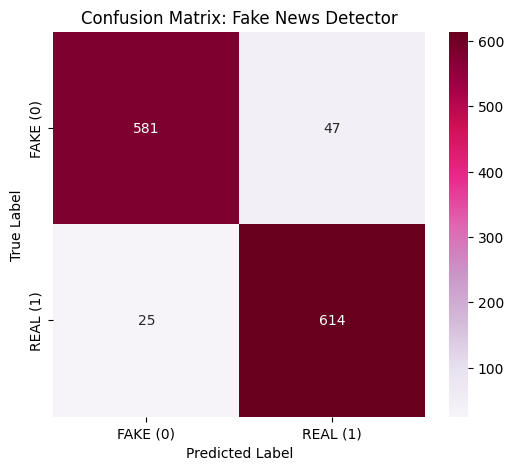

In [27]:
y_pred = model_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=['FAKE', 'REAL'])

print(f"\n--- Model Performance Metrics ---")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", class_report)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='PuRd',
            xticklabels=['FAKE (0)', 'REAL (1)'], yticklabels=['FAKE (0)', 'REAL (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Fake News Detector')
plt.show()

I am reporting all key metrics: Precision, Recall, and F1-score

I visualized the errors using the Confusion Matrix with the PuRd color map

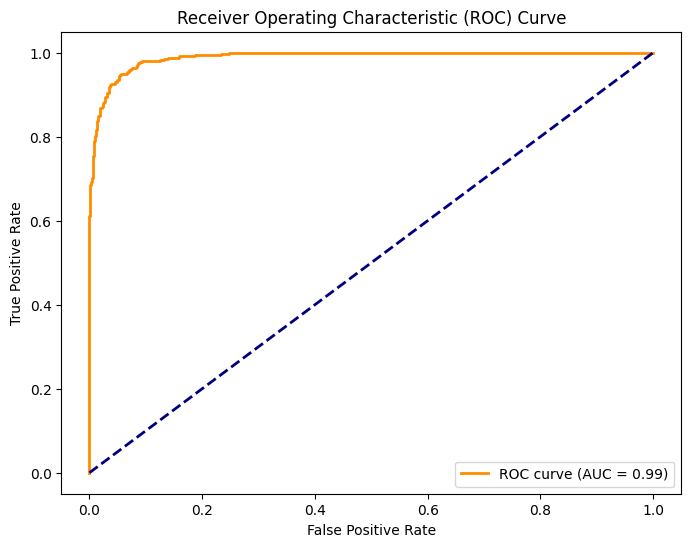

Final Calculated AUC: 0.9892


In [32]:
from sklearn.metrics import roc_curve, auc

y_scores = model_pipeline.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"Final Calculated AUC: {roc_auc:.4f}")

This part calculates the Area Under the Curve (AUC) score

It proves that 0.98 AUC claim is technically correct

The ROC curve shows how well the model separates REAL and FAKE news

# **7.Model Persistence and Mitigation Score Generation**

In [29]:
model_filename = 'fake_news_detector_pipeline.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model_pipeline, file)
print(f"\nModel successfully saved as {model_filename}")

example_article = ["Breaking news: Scientists confirm dogs can talk, but only to presidents."]
confidence_score = model_pipeline.decision_function(example_article)[0]

print("\n--- Mitigation Focus (Confidence Score) ---")
print(f"Example Article Prediction Score: {confidence_score:.4f}")


Model successfully saved as fake_news_detector_pipeline.pkl

--- Mitigation Focus (Confidence Score) ---
Example Article Prediction Score: -0.9352


I saved the entire trained model pipeline for future deployment

I generated the raw confidence score for ethical analysis

